In [246]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample

### Load data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [341]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_canonized.pkl'))

In [342]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [356]:
# create mock canonicity scale variable
canon_scale = [sample(range(1, 6), 1)[0] for i in range(len(df['canon']))]
df['canon_scale'] = canon_scale

### Add image embeddings

Image embeddings are obtained by running the script 'src/smk_embeddings.py'. The pretrained model used is EVA-02-CLIP, a multimodal vision transformer architecture. The embeddings are saved as a .npy file in the /data folder.

We load the embeddings from the paintings 'as they are' as well as embeddings where all images were converted to greyscale first.

In [357]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [358]:
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [359]:
# need to convert to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [360]:
# make sure embeddings are still np arrays and has the correct dim
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


### Sanity check embeddings

Checking that our embeddings actually capture image content and style by running a kNN algorithm to find the nearest neighbors based on embeddings:

In [361]:
feature_list = np.array(df['embedding'].tolist())

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


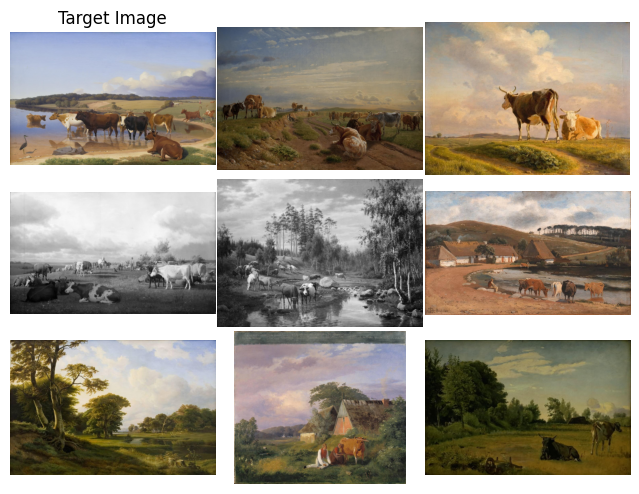

In [362]:
plot_neighbors(feature_list, 80, ds) # choose random image as target image

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


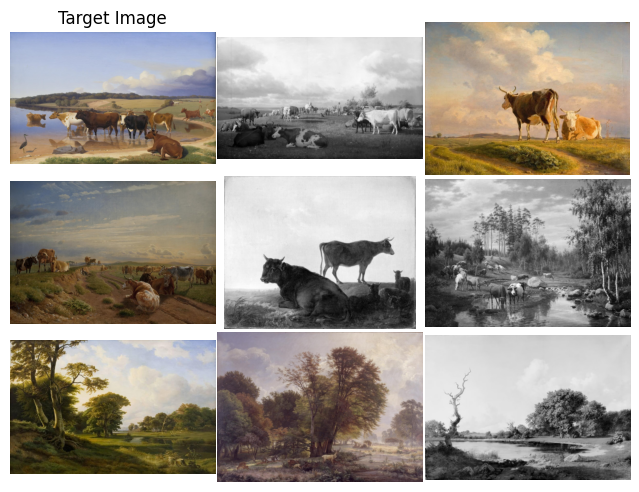

In [363]:
grey_feature_list = np.array(df['grey_embedding'].tolist())
plot_neighbors(grey_feature_list, 80, ds) # choose random image as target image

(Should be noted that I have not changed the actual PIL image to greyscale in the dataset, only done it before extracting the embedding, i.e., have not saved the greyscaled image. That is why the images are still colored)

In [364]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)

In [365]:
color_subset.reset_index(drop = True)

smk_id     period  start_year  \
0           KKSgb20565  1803-1861        1803   
1           KKSgb18206  1778-1841        1778   
2           KKSgb17569  1799-1860        1799   
3           KKSgb17570  1799-1860        1799   
4           KKSgb17568  1799-1860        1799   
...                ...        ...         ...   
1363           KMS8925  1788-1792        1788   
1364           KMS9021  1825-1829        1825   
1365           KMS9034       1868        1868   
1366  KKS13446/223slet       1829        1829   
1367        KKSgb15167  1803-1861        1803   

                                                  title  \
0     Udsigt fra Rundetårn over København til Freder...   
1                                        Mand med slæde   
2                                         Eksotisk fugl   
3                                         Eksotisk fugl   
4                                                  Fugl   
...                                                 ...   
1363    Portræt af Kennett Dixon, der spiller badminton   
1364                                        Selvportræt   
1365      Portræt af maleren Thorald Læssøe (1816-1878)   
1366                                      tekst og node   
1367  Rysensteens badeanstalt med udsigt over Langeb...   

                             first_artist  \
0                             H.G.F. Holm   
1     Sigmund Ferdinand Ritter von Perger   
2            Johan Christian Ernst Walter   
3            Johan Christian Ernst Walter   
4            Johan Christian Ernst Walter   
...                                   ...   
1363                      William Beechey   
1364                Emil Ditlev Bærentzen   
1365           Elisabeth Jerichau Baumann   
1366                             Ubekendt   
1367                          H.G.F. Holm   

                                all_artists  num_artists main_type  \
0                             [H.G.F. Holm]            1   Akvarel   
1     [Sigmund Ferdinand Ritter von Perger]            1   Akvarel   
2            [Johan Christian Ernst Walter]            1   Gouache   
3            [Johan Christian Ernst Walter]            1   Gouache   
4            [Johan Christian Ernst Walter]            1   Gouache   
...                                     ...          ...       ...   
1363                      [William Beechey]            1    Maleri   
1364                [Emil Ditlev Bærentzen]            1    Maleri   
1365           [Elisabeth Jerichau Baumann]            1    Maleri   
1366                             [Ubekendt]            1   Akvarel   
1367                          [H.G.F. Holm]            1   Akvarel   

               all_types                                    image_thumbnail  \
0     [Akvarel, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/w3763b937_kk...   
1     [Akvarel, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/ws859k68q_kk...   
2     [Gouache, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/np193f181_kk...   
3     [Gouache, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/hm50tx28p_kk...   
4     [Gouache, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/pc289p10p_kk...   
...                  ...                                                ...   
1363            [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/rf55zc238_km...   
1364            [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/9880vw79j_km...   
1365            [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/sb397d185_km...   
1366           [Akvarel]  https://api.smk.dk/api/v1/thumbnail/d6306744-5...   
1367  [Akvarel, Tegning]  https://iip-thumb.smk.dk/iiif/jp2/7h149v34g_kk...   

      ... exb_canon docs_len docs_canon  canon n_exhibitions n_golden_titles  \
0     ...         1        1          0  canon             2            <NA>   
1     ...         0        0          0  other          <NA>            <NA>   
2     ...         0        0          0  other          <NA>            <NA>   
3     ...         0        0          0  other          <NA>       

## Test Paper 1 workflow

In [366]:
def plot_pca_binary(ax, df, embeddings_column, title, colormapping):
    
    # Handle embeddings
    embeddings_array = np.array(df[embeddings_column].to_list(), dtype=np.float32)

    # Make labels titlecase
    colormapping = {k.title(): v for k, v in colormapping.items()}
    
    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    
    # Add metadata
    df_pca["canon"] = df["canon"].values
    df_pca["canon"] = df_pca["canon"].apply(lambda x: x.title())

    # We're gonna set a different alpha for the 'O' category
    alpha_dict = dict(zip(colormapping.keys(), [0.65 if x != 'other' else 0.2 for x in colormapping.keys()]))
    # Update color dict to have titlecase

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=colormapping.get(category),
            label=category,
            alpha=alpha,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in colormapping.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    ax.axis("equal")

Creating PCA plot based on a preliminary binary canon definition (that I just defined for testing purposes). A painting is defined as canon if it has previously been part of an exhibition or is currently at display at SMK.

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

Text(0.5, 0.98, 'PCA with Binary Canon Definition')

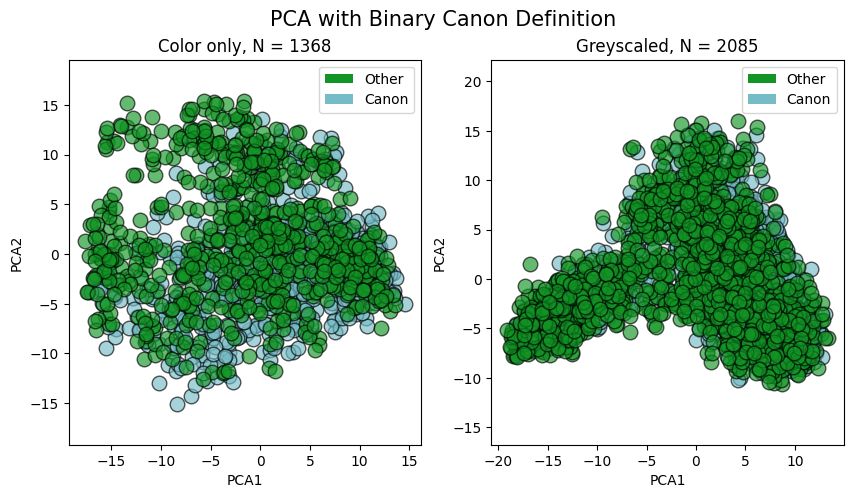

In [367]:
color_mapping = {'other': '#129525', 'canon': '#75BCC6'}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_pca_binary(axs[0], color_subset, 'embedding', f"Color only, N = {len(color_subset)}", color_mapping)
plot_pca_binary(axs[1], df, 'grey_embedding', f"Greyscaled, N = {len(df)}", color_mapping)
fig.suptitle('PCA with Binary Canon Definition', size = 15)

In [368]:
def plot_pca_scale(ax, df, embeddings_column, title):
    
    # Handle embeddings
    embeddings_array = np.array(df[embeddings_column].to_list(), dtype=np.float32)

    # Make labels titlecase
    #colormapping = {k.title(): v for k, v in colormapping.items()}
    
    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    
    # Add metadata
    df_pca["canon"] = df["canon_scale"].values
    #df_pca["canon"] = df_pca["canon"].apply(lambda x: x.title())

    # We're gonna set a different alpha for the 'O' category
    #alpha_dict = dict(zip(colormapping.keys(), [0.65 if x != 'other' else 0.2 for x in colormapping.keys()]))
    # Update color dict to have titlecase

    # Plot each category
    scatterplot = ax.scatter(df_pca["PCA1"], df_pca["PCA2"], c=df_pca["canon"], marker='o', cmap='BuGn', alpha = 0.7)
    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.axis("equal")

    return scatterplot


    #legend_handles = [Patch(facecolor=color, label=label) for label, color in colormapping.items()]
    #ax.legend(handles=legend_handles, loc='upper right')

Testing PCA plots with a continuous canon variable by assigning each painting a random number between 1-5

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

Text(0.5, 0.98, 'PCA with Mock Canon Scale Definition')

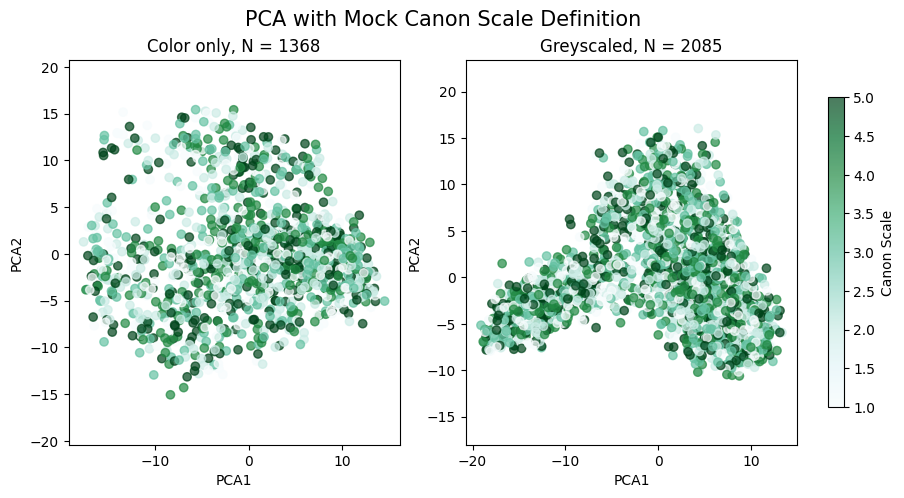

In [369]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sc1 = plot_pca_scale(axs[0], color_subset, 'embedding', f"Color only, N = {len(color_subset)}")
sc2 = plot_pca_scale(axs[1], df, 'grey_embedding', f"Greyscaled, N = {len(df)}")

# add colorbar
cbar = fig.colorbar(sc1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Canon Scale")
fig.suptitle('PCA with Mock Canon Scale Definition', size = 15)

In [376]:
def pca_per_category(ax, df, embedding, canon_category, title):
    embeddings_array = np.array(df[embedding].to_list(), dtype=np.float32)
    
    color_mapping = {'Other': '#129525', 'Canon': '#75BCC6'}

    column_mapped = df[canon_category].replace({0: 'Other', 1: 'Canon'})

    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])

    df_pca["canon"] = column_mapped.values

    alpha_dict = dict(zip(color_mapping.keys(), [0.65 if x != 'Other' else 0.2 for x in color_mapping.keys()]))

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=color_mapping.get(category),
            label=category,
            alpha=alpha,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in color_mapping.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    ax.axis("equal")

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

Text(0.5, 0.95, 'PCA with Binary Canon Definition by category')

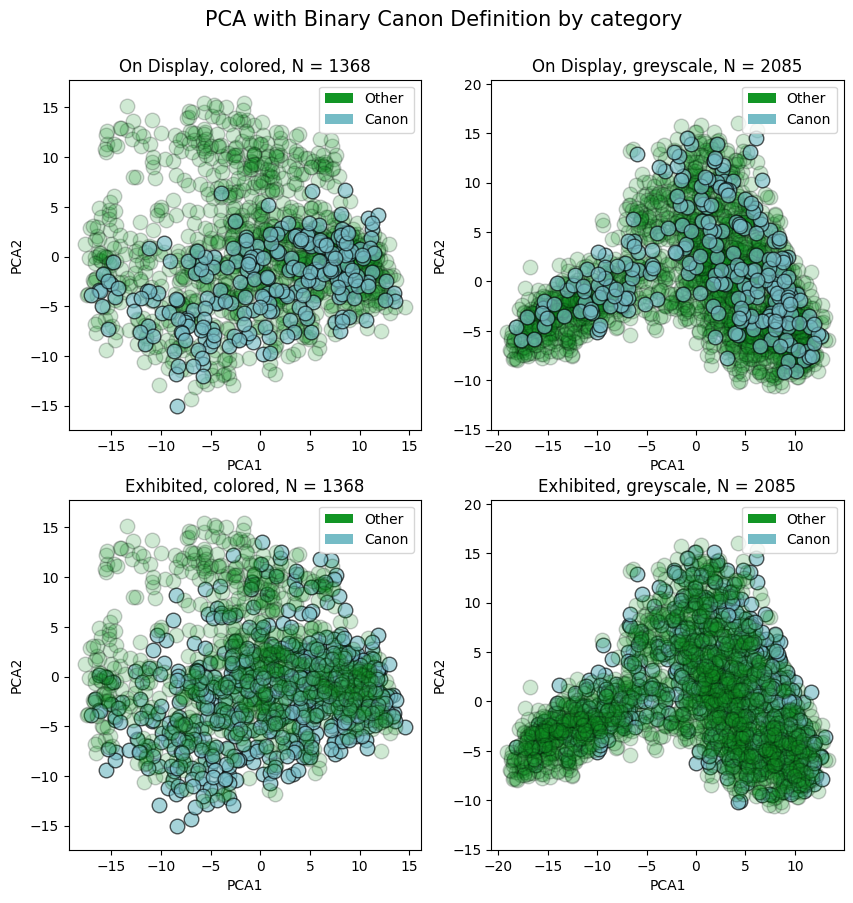

In [383]:
# PCA plots with binary canon variable
color_mapping = {'other': '#129525', 'canon': '#75BCC6'}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

pca_per_category(axs[0,0], color_subset, 'embedding', "on_display", f"On Display, colored, N = {len(color_subset)}")
pca_per_category(axs[0,1], df, 'grey_embedding', "on_display", f"On Display, greyscale, N = {len(df)}")
pca_per_category(axs[1,0], color_subset, 'embedding', "exb_canon", f"Exhibited, colored, N = {len(color_subset)}")
pca_per_category(axs[1,1], df, 'grey_embedding', "exb_canon", f"Exhibited, greyscale, N = {len(df)}")
fig.suptitle('PCA with Binary Canon Definition by category', size = 15, y=0.95)

### Plot PCA embeddings for first and last part of the dataset

In [386]:
# dividing the dataset based on the median
df['start_year'].describe()

count    2085.000000
mean     1818.245084
std        32.432521
min      1750.000000
25%      1792.000000
50%      1828.000000
75%      1843.000000
max      1870.000000
Name: start_year, dtype: float64

In [387]:
first_half_grey = df.query("start_year < 1828")
second_half_grey = df.query("start_year >= 1828")
len(df) == len(first_half_grey) + len(second_half_grey)

True

In [388]:
# get median for color-subset
color_subset['start_year'].describe()

count    1368.000000
mean     1822.513889
std        30.686295
min      1750.000000
25%      1803.000000
50%      1832.000000
75%      1845.000000
max      1870.000000
Name: start_year, dtype: float64

In [389]:
first_half_color = color_subset.query("start_year < 1832")
second_half_color = color_subset.query("start_year >= 1832")

len(color_subset) == len(first_half_color) + len(second_half_color)

True

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

Text(0.5, 0.95, 'PCA with Binary Canon Definition, divided by years')

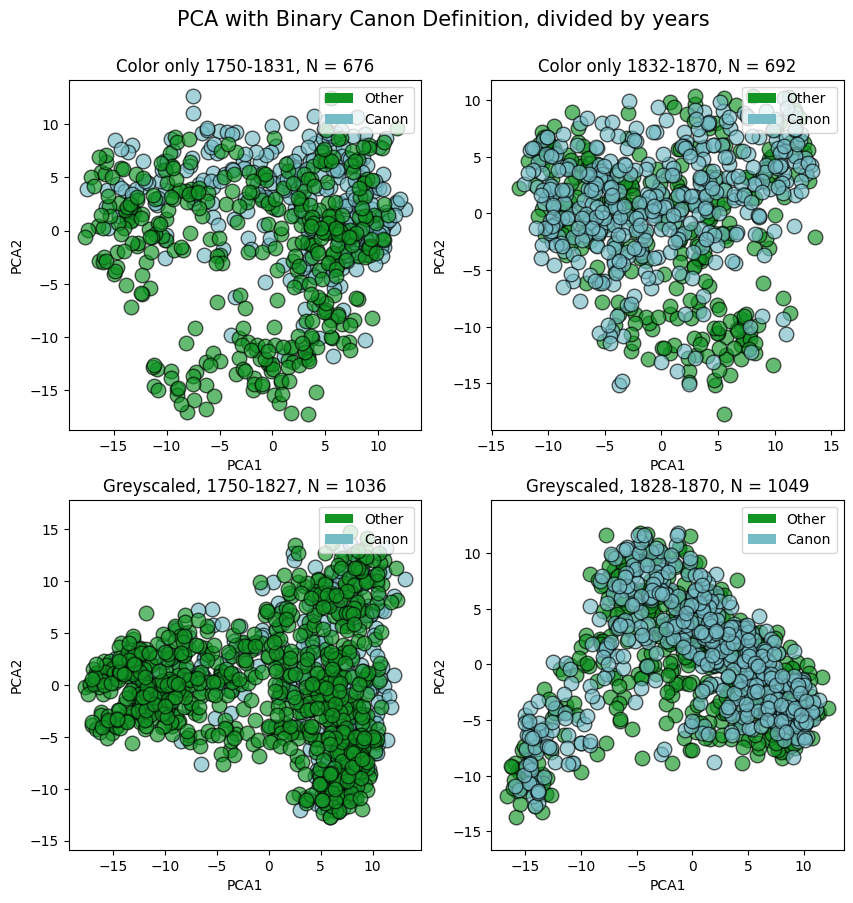

In [391]:
# PCA plots with binary canon variable
color_mapping = {'other': '#129525', 'canon': '#75BCC6'}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_pca_binary(axs[0,0], first_half_color, 'embedding', f"Color only 1750-1831, N = {len(first_half_color)}", color_mapping)
plot_pca_binary(axs[0,1], second_half_color, 'embedding', f"Color only 1832-1870, N = {len(second_half_color)}", color_mapping)
plot_pca_binary(axs[1,0], first_half_grey, 'grey_embedding', f"Greyscaled, 1750-1827, N = {len(first_half_grey)}", color_mapping)
plot_pca_binary(axs[1,1], second_half_grey, 'grey_embedding', f"Greyscaled, 1828-1870, N = {len(second_half_grey)}", color_mapping)

fig.suptitle('PCA with Binary Canon Definition, divided by years', size = 15, y=0.95)

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

Text(0.5, 0.95, 'PCA with Mock Canon Scale Definition, divided by years')

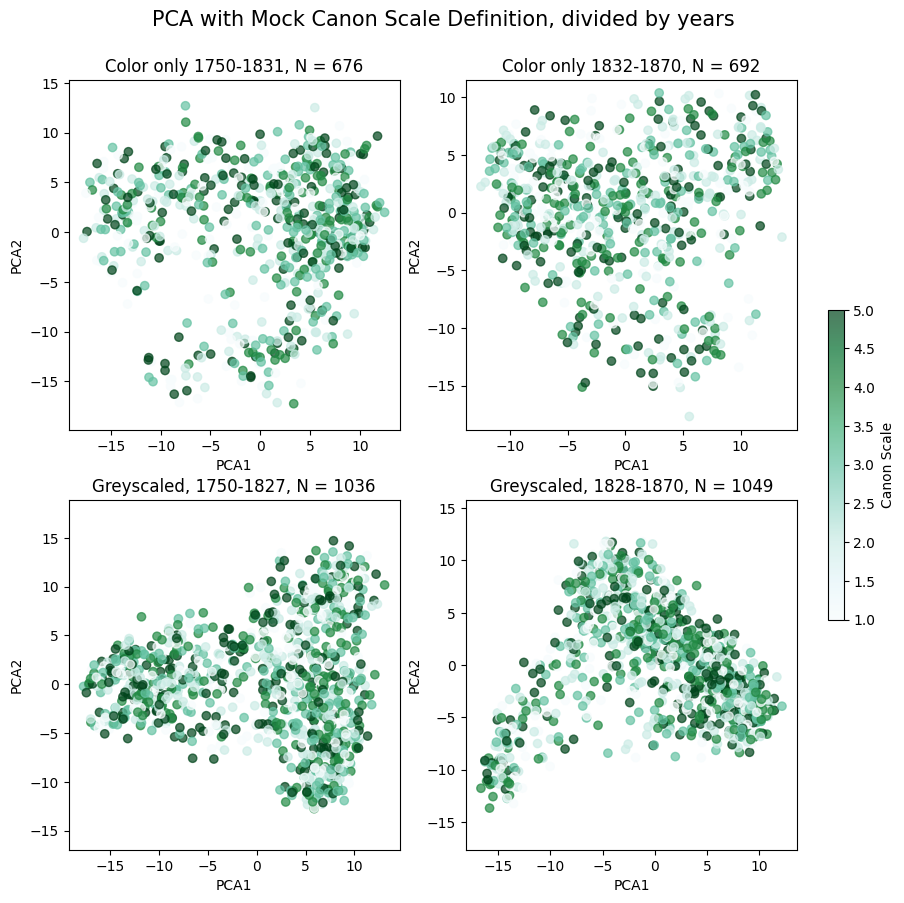

In [392]:
# PCA plots with canon scale
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sc1 = plot_pca_scale(axs[0,0], first_half_color, 'embedding', f"Color only 1750-1831, N = {len(first_half_color)}")
sc2 = plot_pca_scale(axs[0,1], second_half_color, 'embedding', f"Color only 1832-1870, N = {len(second_half_color)}")
sc3 = plot_pca_scale(axs[1,0], first_half_grey, 'grey_embedding', f"Greyscaled, 1750-1827, N = {len(first_half_grey)}")
sc4 = plot_pca_scale(axs[1,1], second_half_grey, 'grey_embedding', f"Greyscaled, 1828-1870, N = {len(second_half_grey)}")

cbar = fig.colorbar(sc2, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Canon Scale")
fig.suptitle('PCA with Mock Canon Scale Definition, divided by years', size = 15, y=0.95)

### Creating dendogram plot

In [412]:
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns

In [418]:
def plot_dendrogram(df, col_to_color, col_to_label, embedding_col, l, h, palette='Set2'):
    
    unique_categories = df[col_to_color].unique()

    # colors
    cat_map = dict(zip(df[col_to_label],df[col_to_color]))
    color_dict = {'other': '#129525', 'canon': '#356177'}#'#FCCA46'}

    # prepare data for plotting
    embeddings_matrix = np.stack(df[embedding_col].values)
    cosine_dist_matrix = cosine_distances(embeddings_matrix)
    
    if cosine_dist_matrix.shape[0] != cosine_dist_matrix.shape[1]:
        raise ValueError("Distance matrix is not square.")

    Z = linkage(cosine_dist_matrix, method='ward')

    # dendrogram plot
    sns.set_style('whitegrid')
    plt.figure(figsize=(l, h))
    dend = dendrogram(Z, labels=df[col_to_label].values, orientation='top', leaf_font_size=5, color_threshold=0, above_threshold_color='black')

    # Labels
    # get x-tick labels
    ax = plt.gca()
    xticklabels = ax.get_xticklabels()

    # apply colors labels
    used_colors = {}
    for tick in xticklabels:
        label = tick.get_text()
        # just to make sure we have no other labels in there
        if label in cat_map:
            value = cat_map[label]
            color = color_dict[value]
            tick.set_color(color)
            used_colors[value] = color
        else:
            tick.set_color('black')
    
    # update labels in used_colors, make titlecase
    used_colors = {k.replace('_', ' ').title(): v for k, v in used_colors.items()}
    # make "other" if O in used_colors
    if 'O' in used_colors:
        used_colors['Other'] = used_colors.pop('O')
    
    # layout
    plt.xlabel("Cosine Distance")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in used_colors.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()
    plt.show()

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_79349/4218318037.py:16: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cosine_dist_matrix, method='ward')


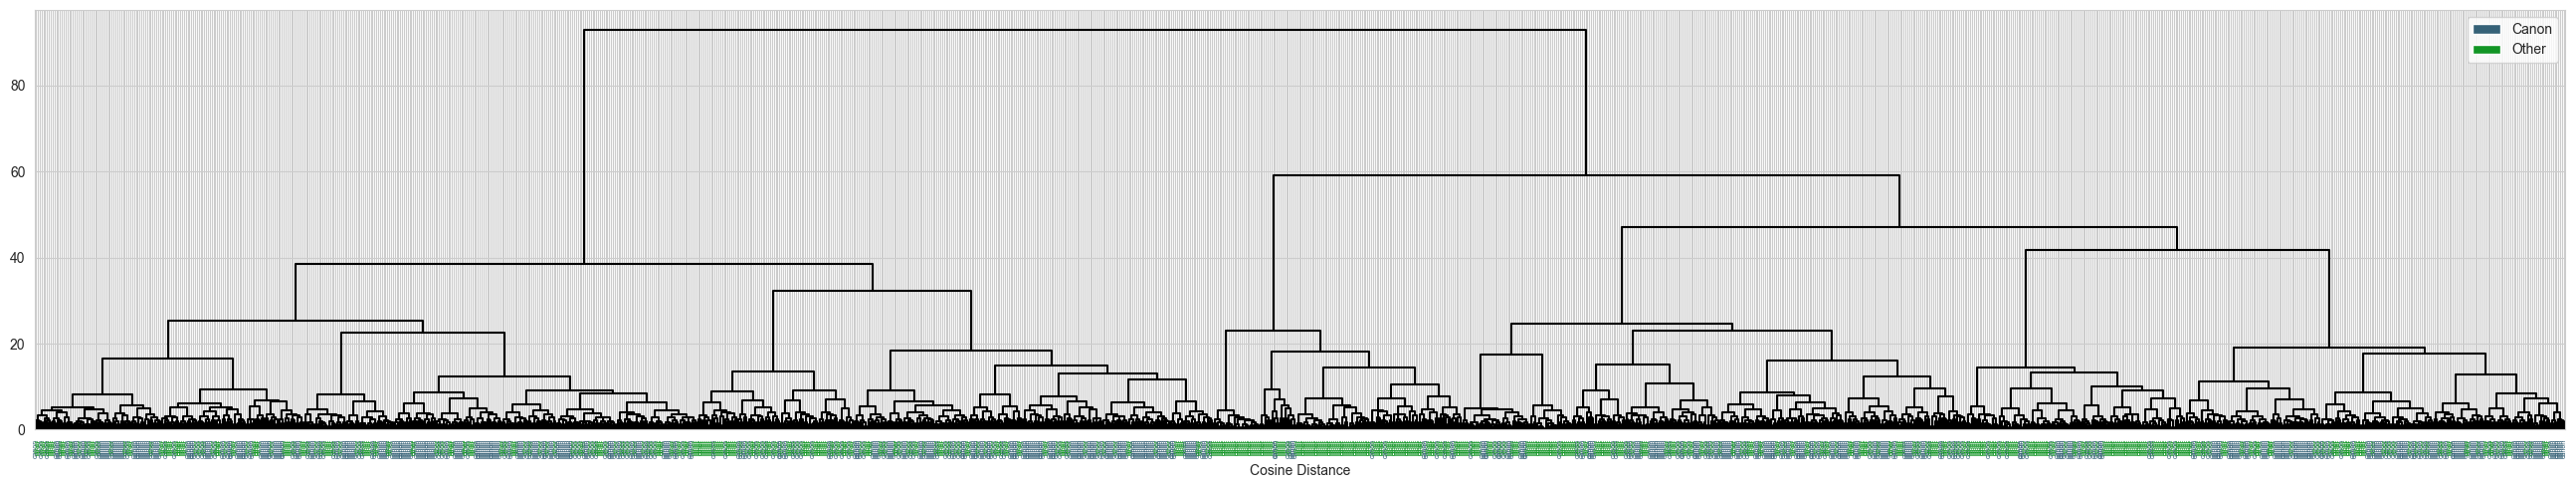

In [419]:
plot_dendrogram(color_subset, 'canon', 'canon', 'embedding', l=26, h=5)

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_79349/4218318037.py:16: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cosine_dist_matrix, method='ward')
/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_79349/4218318037.py:53: UserWarning: Tight layo

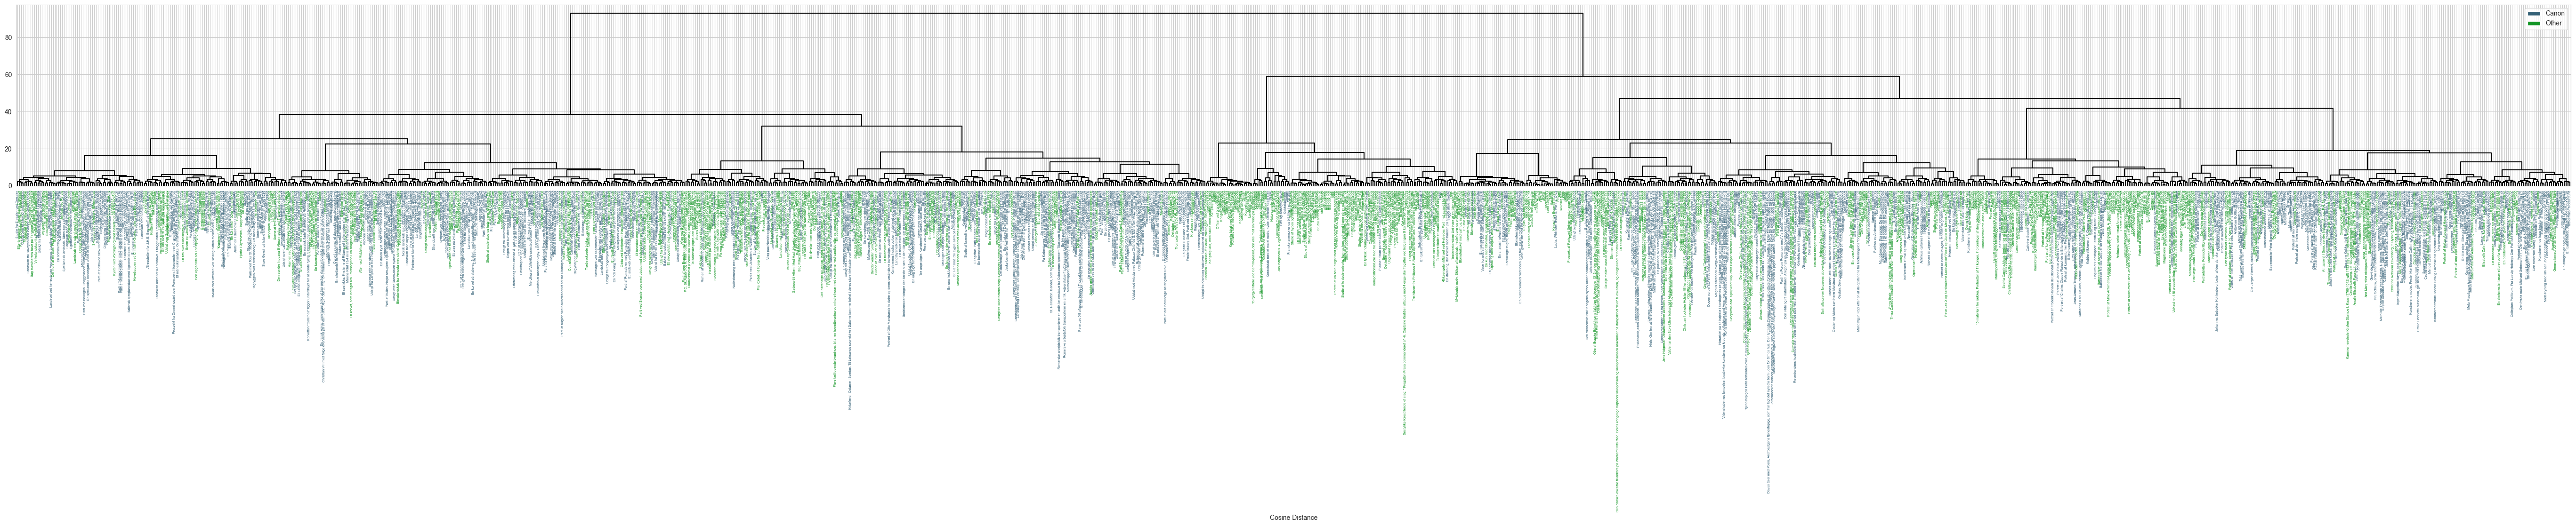

In [421]:
plot_dendrogram(color_subset, 'canon', 'title', 'embedding', l=70, h=5)

# Measure diachronic change (= variance in embeddings over time)

#### Naive approach (no up or downsampling)

In [307]:
canon_df = df.query("canon == 'canon'")

In [310]:
## Start a loop over the years
mean_similarity_dict = {}

# window size and step size
window_size = 4
step_size = 1

# set sampling
sampling = False
sample_size = 4

# increase if we want to do more runs
number_of_runs = 1

# Get the minimum and maximum years in the dataset
min_year = df['start_year'].min()
max_year = df['start_year'].max()

In [302]:
embeddings = np.stack(df['embedding'].values)
test = cosine_similarity(embeddings)

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [306]:
test.mean()

np.float64(0.4060066343061436)

In [311]:
def get_cosim_mean_std(key):
    data = group_eb[key]
    embeddings = np.stack(data['embedding'].values)
    mean_cosim = cosine_similarity(embeddings).mean()
    std_cosim = cosine_similarity(embeddings).std()
    
    return mean_cosim, std_cosim

In [313]:
for start_year in range(min_year, max_year - window_size + 1, step_size):
    # Define rolling window range for each window
    year_range = list(range(start_year, start_year + window_size))

    print(year_range)

[1750, 1751, 1752, 1753]
[1751, 1752, 1753, 1754]
[1752, 1753, 1754, 1755]
[1753, 1754, 1755, 1756]
[1754, 1755, 1756, 1757]
[1755, 1756, 1757, 1758]
[1756, 1757, 1758, 1759]
[1757, 1758, 1759, 1760]
[1758, 1759, 1760, 1761]
[1759, 1760, 1761, 1762]
[1760, 1761, 1762, 1763]
[1761, 1762, 1763, 1764]
[1762, 1763, 1764, 1765]
[1763, 1764, 1765, 1766]
[1764, 1765, 1766, 1767]
[1765, 1766, 1767, 1768]
[1766, 1767, 1768, 1769]
[1767, 1768, 1769, 1770]
[1768, 1769, 1770, 1771]
[1769, 1770, 1771, 1772]
[1770, 1771, 1772, 1773]
[1771, 1772, 1773, 1774]
[1772, 1773, 1774, 1775]
[1773, 1774, 1775, 1776]
[1774, 1775, 1776, 1777]
[1775, 1776, 1777, 1778]
[1776, 1777, 1778, 1779]
[1777, 1778, 1779, 1780]
[1778, 1779, 1780, 1781]
[1779, 1780, 1781, 1782]
[1780, 1781, 1782, 1783]
[1781, 1782, 1783, 1784]
[1782, 1783, 1784, 1785]
[1783, 1784, 1785, 1786]
[1784, 1785, 1786, 1787]
[1785, 1786, 1787, 1788]
[1786, 1787, 1788, 1789]
[1787, 1788, 1789, 1790]
[1788, 1789, 1790, 1791]
[1789, 1790, 1791, 1792]


In [ ]:
for start_year in range(min_year, max_year - window_size + 1, step_size):

    temp = {}

    # Define rolling window range for each window
    year_range = list(range(start_year, start_year + window_size))
    range_label = f"{year_range[0]}-{year_range[-1]}"

    canon = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] == 'canon')]

    df_total = df.loc[df['start_year'].isin(year_range)]

    group_eb = {'canon': canon, 'df_total': df_total}

    #if sampling == True:
    # sample from the groups

       # for key in group_eb:
        #    group = group_eb[key]
        #    group_eb[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group
    
    
    # get the mean embeddings of the current window for each group
    canon_mean = group_eb['canon']['embedding'].mean(axis=0)
    non_canon_mean = group_eb['non_canon']['embedding'].mean(axis=0)

    # get the cosine similarity btw canon and non-canon
    canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity

    # save
    #mean_similarity_dict[range_label] = temp

    # get canon embeddings
    canon_mean, canon_std = get_cosim_mean_std('canon')
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_STD'] = canon_std

    nc_mean, nc_std = get_cosim_mean_std('non_canon')
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_STD'] = nc_std

    t_mean, t_std = get_cosim_mean_std('df_total')
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_STD'] = t_std

    temp['n_paintings'] = [len(df_total), len(canon), len(non_canon)]
    mean_similarity_dict[range_label] = temp

# Format df
sim_df = pd.DataFrame.from_dict(mean_similarity_dict, orient='index').reset_index()
sim_df = sim_df.rename(columns={"index": "year_RANGE"})

sim_df['START_year'] = sim_df['year_RANGE'].apply(lambda x: int(x.split('-')[0]))
    

    #windows_list.append(temp)


ValueError: all input arrays must have the same shape

In [235]:
sim_df

NameError: name 'sim_df' is not defined

In [234]:
plt.plot(sim_df['START_year'], sim_df['CANON_NONCANON_COSIM'], color='#75BCC6', linewidth=2, 
             alpha=0.3)
plt.title("Canon vs Non-Canon Cosine Similarity Over Time")

NameError: name 'sim_df' is not defined

In [ ]:
plt.plot(sim_df['START_year'], sim_df['NONCANON_COSIM_MEAN'])

In [ ]:
plt.plot(sim_df['START_year'], sim_df['CANON_COSIM_MEAN'])

In [ ]:
df.query('smk_exhibitions == True')

In [238]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'canon_scale', 'embedding',
       'grey_embedding'],
      dtype='object')

#### Inter-group similarity

we want to see if the difference btw canon and noncanon decreases over time